## KEY VARIABLES
* Youtube_ID obviously designates the video to analyze.
* Frame step designates how many frames per second to analyze with OpenPose. Default fps is 24 frames per second.


In [0]:
YOUTUBE_ID = 'Ci3na6ThUJc'
# Frame_step also has to be set manually @ preprocessing!
FRAMESTEP = 6

# **Preparation**

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


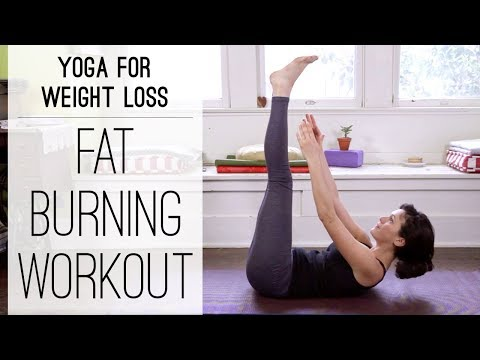

In [2]:
import time

# Pick and show Youtube video
### Elderly yoga example: YOUTUBE_ID = 'kFhG-ZzLNN4'
### Default example: YOUTUBE_ID = 'nQFf38xeBww'

#Import required modules
import pandas as pd
from pandas.io.json import json_normalize
from pathlib import Path
import json
from IPython.display import YouTubeVideo
from google.colab import drive
import os
from os.path import exists, join, basename, splitext
from IPython.display import clear_output
import os
from __future__ import print_function
from __future__ import division
import cv2 as cv
import numpy as np
import argparse
import glob
import imutils
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from IPython.display import Image
import PIL
import warnings
from scipy.spatial import procrustes 
import sys
import seaborn as sns
import scipy as sp
from scipy.spatial import distance
from scipy.signal import savgol_filter
import sklearn
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from scipy.signal import argrelextrema

#Options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.filterwarnings("ignore", category=FutureWarning) 

#Mount google drive
drive.mount('/content/drive', force_remount=True)

YouTubeVideo(YOUTUBE_ID)

In [3]:
#Load preprocessed pose information.

path = r'/content/drive/My Drive/Thesis/Poseinformation/'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
  df = pd.read_csv(filename, index_col=None, header=0)
  li.append(df)

poseinformation = pd.concat(li, axis=0, ignore_index=True)


print(poseinformation.shape)
print(len(filename))

poseinformation.head()

(8416, 78)
85


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,Filename,Imagename
0,0,1398.63,762.838,0.909027,1327.97,836.331,0.736783,1289.63,789.357,0.555307,0.00,0.000,0.000000,0.0,0.0,0.0,1357.36,880.584,0.630559,1539.73,904.172,0.881850,1469.25,853.994,0.714918,1077.69,818.765,0.246812,1065.95,830.476,0.312242,989.427,848.129,0.534102,0.00,0.000,0.000000,0.00,0.00,0.000000,0.00,0.000,0.000000,0.0,0.0,0.0,1407.38,742.261,0.876592,1428.09,777.473,0.840194,0.0,0.0,0.0,1445.72,833.354,0.847035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000000,/content/drive/My Drive/Thesis/json_output/youtube_timecode_000000049758_keypoints.json,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000049758_rendered.png
1,1,1392.69,762.746,0.900018,1333.75,836.462,0.723972,1304.31,801.050,0.572285,1336.77,809.931,0.138034,0.0,0.0,0.0,1360.31,880.510,0.581541,1536.89,906.914,0.872526,1469.22,853.956,0.677776,1080.63,821.636,0.219676,1063.04,830.505,0.291557,995.229,845.188,0.525002,0.00,0.000,0.000000,0.00,0.00,0.000000,0.00,0.000,0.000000,0.0,0.0,0.0,1401.50,742.122,0.909301,1424.92,768.673,0.935737,0.0,0.0,0.0,1445.67,827.573,0.833414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000000,/content/drive/My Drive/Thesis/json_output/youtube_timecode_000000049764_keypoints.json,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000049764_rendered.png
2,2,1389.72,759.740,0.833027,1333.77,839.345,0.657521,1301.45,806.922,0.578033,1392.63,895.274,0.123994,0.0,0.0,0.0,1369.11,880.602,0.487614,1533.98,906.898,0.832208,1463.32,848.131,0.635857,1083.58,824.584,0.211732,1065.99,833.376,0.283415,992.351,842.251,0.499800,0.00,0.000,0.000000,0.00,0.00,0.000000,0.00,0.000,0.000000,0.0,0.0,0.0,1398.60,739.305,0.885218,1422.09,765.657,0.944872,0.0,0.0,0.0,1445.52,827.498,0.807690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000000,/content/drive/My Drive/Thesis/json_output/youtube_timecode_000000049770_keypoints.json,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000049770_rendered.png
3,3,1386.79,753.942,0.818364,1330.77,836.520,0.702477,1295.56,801.047,0.563939,1339.68,812.828,0.119304,0.0,0.0,0.0,1357.31,880.571,0.587224,1533.94,906.919,0.856188,1454.46,842.340,0.695921,1074.84,818.703,0.221764,1068.83,842.277,0.244194,989.390,842.285,0.507297,1054.23,736.324,0.119513,1060.11,798.11,0.231234,1115.92,594.992,0.283687,0.0,0.0,0.0,1398.52,739.120,0.869216,1422.03,762.908,0.941090,0.0,0.0,0.0,1442.59,827.506,0.786774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1071.85,739.352,0.127852,/content/drive/My Drive/Thesis/json_output/youtube_timecode_000000049776_keypoints.json,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000049776_rendered.png
4,4,1383.87,753.963,0.828811,1330.81,839.310,0.684474,1298.50,803.994,0.562982,1339.72,812.868,0.128288,0.0,0.0,0.0,1354.44,880.552,0.559137,1533.88,906.973,0.842141,1451.61,842.302,0.699980,1071.83,815.846,0.206759,1063.02,845.232,0.148366,989.435,845.190,0.316570,0.00,0.000,0.000000,0.00,0.00,0.000000,0.00,0.000,0.000000,0.0,0.0,0.0,1398.43,739.132,0.863840,1421.96,762.859,0.938894,0.0,0.0,0.0,1439.80,824.646,0.781134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000000,/content/drive/My Drive/Thesis/json_output/youtube_timecode_000000049782_keypoints.json,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000049782_rendered.png


# Shot Boundary Detection

In [4]:
#Process files for shot boundary detection or load a preprocessed file if there is one.

#Thanks to: https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html
#Thanks to: https://www.pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/

if os.path.isfile('/content/drive/My Drive/Thesis/SBD_' + YOUTUBE_ID + '_preprocessed.csv') == True:
  df_HistCompare = pd.read_csv('/content/drive/My Drive/Thesis/SBD_' + YOUTUBE_ID + '_preprocessed.csv', sep=',')
  print('Loaded preprocessed file')
else:
  filenames = []
  for root, dirs, files in os.walk(r'/content/drive/My Drive/Thesis/jpg_output/'):
      for file in files:
          if file.endswith('.png'):
              filenames.append(file)
  print("Number of files to analyze:", len(filenames))
  df_HistCompare = pd.DataFrame({'Method': [], 'Base_Base': [], 'Base_Test1': [], 'Image1': [], 'Image2': []})

  num_frames = sum([len(files) for r, d, files in os.walk("/content/drive/My Drive/Thesis/jpg_output")])

  i = 0
  for filenames[i] in filenames:
    print('File ', i, ' of ', num_frames)
    image1 = "/content/drive/My Drive/Thesis/jpg_output/" + filenames[i]
    #Exception handling in case we've gone through all files.
    try:
      image2 = "/content/drive/My Drive/Thesis/jpg_output/" + filenames[i+1]
    except IndexError:
      break

    #print(image1, image2)

    src_base = cv.imread(image1)
    src_test1 = cv.imread(image2)

    if src_base is None or src_test1 is None:# or src_test2 is None:
        print('Could not open or find the images!')
        continue

    ## [Convert to HSV]
    hsv_base = cv.cvtColor(src_base, cv.COLOR_BGR2HSV)
    hsv_test1 = cv.cvtColor(src_test1, cv.COLOR_BGR2HSV)
    #hsv_test2 = cv.cvtColor(src_test2, cv.COLOR_BGR2HSV)
    ## [Convert to HSV]

    ## [Convert to HSV half]
    hsv_half_down = hsv_base[hsv_base.shape[0]//2:,:]
    ## [Convert to HSV half]

    ## [Using 50 bins for hue and 60 for saturation]
    h_bins = 50
    s_bins = 60
    histSize = [h_bins, s_bins]

    # hue varies from 0 to 179, saturation from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    ranges = h_ranges + s_ranges # concat lists

    # Use the 0-th and 1-st channels
    channels = [0, 1]
    ## [Using 50 bins for hue and 60 for saturation]

    ## [Calculate the histograms for the HSV images]
    hist_base = cv.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
    cv.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

    hist_half_down = cv.calcHist([hsv_half_down], channels, None, histSize, ranges, accumulate=False)
    cv.normalize(hist_half_down, hist_half_down, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

    hist_test1 = cv.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
    cv.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

    #hist_test2 = cv.calcHist([hsv_test2], channels, None, histSize, ranges, accumulate=False)
    #cv.normalize(hist_test2, hist_test2, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
    ## [Calculate the histograms for the HSV images]

    ## [Apply the histogram comparison methods]
    for compare_method in range(4):
        base_base = cv.compareHist(hist_base, hist_base, compare_method)
        #base_half = cv.compareHist(hist_base, hist_half_down, compare_method)
        base_test1 = cv.compareHist(hist_base, hist_test1, compare_method)
        #base_test2 = cv.compareHist(hist_base, hist_test2, compare_method)

        #print('Method:', compare_method, 'Perfect, Base-Half, Base-Test(1):',\
        #      base_base, '/', base_half, '/', base_test1, '/', asps[i], asps[i+1])# '/', base_test2)
        df_HistCompare = df_HistCompare.append({'Method': compare_method, 'Base_Base': base_base, 'Base_Test1': base_test1, 'Image1': filenames[i], 'Image2': filenames[i+1]}, ignore_index=True)
    i += 1
    if i % 10 == 0:
      clear_output()

  ##Optionally save to file
  df_HistCompare.to_csv(path_or_buf='/content/drive/My Drive/Thesis/SBD_' + YOUTUBE_ID + '_preprocessed.csv')

Loaded preprocessed file


In [5]:
#Check initial results
df_HistCompare.head()

,Unnamed: 0,Method,Base_Base,Base_Test1,Image1,Image2
0,0,0.0,1.000000e+00,0.999637,youtube_timecode_000000049758_rendered.png,youtube_timecode_000000049764_rendered.png
1,1,1.0,0.000000e+00,0.109521,youtube_timecode_000000049758_rendered.png,youtube_timecode_000000049764_rendered.png
2,2,2.0,1.301401e+01,12.704034,youtube_timecode_000000049758_rendered.png,youtube_timecode_000000049764_rendered.png
3,3,3.0,1.053671e-08,0.033244,youtube_timecode_000000049758_rendered.png,youtube_timecode_000000049764_rendered.png
4,4,0.0,1.000000e+00,0.999297,youtube_timecode_000000049764_rendered.png,youtube_timecode_000000049770_rendered.png


In [0]:
#df_HistCompare = pd.read_csv('drive/My Drive/Thesis/openpose.avi_r8904530ijyiopf9034jiop4g90j0yh795640h38j/frames_elderly_preprocessed.csv')

#Prepare dataframes for plotting of different methods (use set options to investigate)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', 1000)

df_HistCompare_Correlation = df_HistCompare[df_HistCompare['Method']==0.0]
df_HistCompare_Chisquare = df_HistCompare[df_HistCompare['Method']==1.0]
df_HistCompare_Intersection = df_HistCompare[df_HistCompare['Method']==2.0]
df_HistCompare_Bhattacharyya = df_HistCompare[df_HistCompare['Method']==3.0]

In [7]:
df_HistCompare_Correlation.head()

,Unnamed: 0,Method,Base_Base,Base_Test1,Image1,Image2
0,0,0.0,1.0,0.999637,youtube_timecode_000000049758_rendered.png,youtube_timecode_000000049764_rendered.png
4,4,0.0,1.0,0.999297,youtube_timecode_000000049764_rendered.png,youtube_timecode_000000049770_rendered.png
8,8,0.0,1.0,0.998745,youtube_timecode_000000049770_rendered.png,youtube_timecode_000000049776_rendered.png
12,12,0.0,1.0,0.999203,youtube_timecode_000000049776_rendered.png,youtube_timecode_000000049782_rendered.png
16,16,0.0,1.0,0.999126,youtube_timecode_000000049782_rendered.png,youtube_timecode_000000049788_rendered.png


In [0]:
#Thanks to: https://stackoverflow.com/questions/39951196/how-to-find-values-below-or-above-average
def zscore(s):
    return (s - np.mean(s)) / np.std(s)
df_HistCompare_Correlation_Cuts = df_HistCompare_Correlation[zscore(df_HistCompare_Correlation['Base_Test1']).abs().gt(2)]
#print(df_HistCompare_Correlation[zscore(df_HistCompare_Correlation['Base_Test1']).abs().gt(2)])
df_HistCompare_Chisquare_Cuts = df_HistCompare_Chisquare[zscore(df_HistCompare_Chisquare['Base_Test1']).abs().gt(2)]
#print(df_HistCompare_Chisquare[zscore(df_HistCompare_Chisquare['Base_Test1']).abs().gt(2)])
df_HistCompare_Intersection_Cuts = df_HistCompare_Intersection[zscore(df_HistCompare_Intersection['Base_Test1']).abs().gt(2)]
#print(df_HistCompare_Intersection[zscore(df_HistCompare_Intersection['Base_Test1']).abs().gt(2)])
df_HistCompare_Bhattacharyya_Cuts = df_HistCompare_Bhattacharyya[zscore(df_HistCompare_Bhattacharyya['Base_Test1']).abs().gt(2)]
#print(df_HistCompare_Bhattacharyya[zscore(df_HistCompare_Bhattacharyya['Base_Test1']).abs().gt(2)])

In [9]:
df_HistCompare_Correlation_Cuts['Image2']
df_HistCompare_Correlation_Cuts['Imagename']  = '/content/drive/My Drive/Thesis/jpg_output/' + df_HistCompare_Correlation_Cuts['Image2'].astype(str)
df_HistCompare_Correlation_Cuts.head()

,Unnamed: 0,Method,Base_Base,Base_Test1,Image1,Image2,Imagename
292,292,0.0,1.0,0.770995,youtube_timecode_000000050196_rendered.png,youtube_timecode_000000050202_rendered.png,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000050202_rendered.png
296,296,0.0,1.0,0.757722,youtube_timecode_000000050202_rendered.png,youtube_timecode_000000050208_rendered.png,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000050208_rendered.png
672,672,0.0,1.0,0.373466,youtube_timecode_000000050766_rendered.png,youtube_timecode_000000050772_rendered.png,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000050772_rendered.png
908,908,0.0,1.0,0.416418,youtube_timecode_000000051120_rendered.png,youtube_timecode_000000051126_rendered.png,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000051126_rendered.png
1304,1304,0.0,1.0,0.404025,youtube_timecode_000000051714_rendered.png,youtube_timecode_000000051720_rendered.png,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000051720_rendered.png


# **Distance calculations**

##Prepare data

In [10]:
#Set column names correctly.
poseinformation.columns = ['Unnamed', 'Nose_X', 'Nose_Y', 'Nose_Conf', 'Neck_X', 'Neck_Y', 'Neck_Conf', 'Rshoulder_X', 'Rshoulder_Y', 'Rshoulder_Conf', 'Relbow_X', 'Relbow_Y', 'Relbow_Conf', 'Rwrist_X', 'Rwrist_Y', 'Rwrist_Conf', 'Lshoulder_X', 'Lshoulder_Y', 'Lshoulder_Conf', 'Lelbow_X', 'Lelbow_Y', 'Lelbow_Conf', 'Lwrist_X', 'Lwrist_Y', 'Lwrist_Conf', 'MidHip_X', 'MidHip_Y', 'MidHip_Conf', 'Rhip_X', 'Rhip_Y', 'Rhip_Conf', 'Rknee_X', 'Rknee_Y', 'Rknee_Conf', 'Rankle_X', 'Rankle_Y', 'Rankle_Conf', 'Lhip_X', 'Lhip_Y', 'Lhip_Conf', 'Lknee_X', 'Lknee_Y', 'Lknee_Conf', 'Lankle_X', 'Lankle_Y', 'Lankle_Conf', 'Reye_X', 'Reye_Y', 'Reye_Conf', 'Leye_X', 'Leye_Y', 'Leye_Conf', 'Rear_X', 'Rear_Y', 'Rear_Conf', 'Lear_X', 'Lear_Y', 'Lear_Conf', 'Lbigtoe_X', 'Lbigtoe_Y', 'Lbigtoe_Conf', 'Lsmalltoe_X', 'Lsmalltoe_Y', 'Lsmalltoe_Conf', 'Lheel_X', 'Lheel_Y', 'Lheel_Conf', 'Rbigtoe_X', 'Rbigtoe_Y', 'Rbigtoe_Conf', 'Rsmalltoe_X', 'Rsmalltoe_Y', 'Rsmalltoe_Conf', 'Rheel_X', 'Rheel_Y', 'Rheel_Conf', 'Filename', 'Imagename']

#Optionally save to file
poseinformation.to_csv(path_or_buf='/content/drive/My Drive/Thesis/json_preprocessed_'+YOUTUBE_ID+'.csv')


poseinformation_clean = poseinformation.replace(0,np.NaN)
poseinformation_clean = poseinformation_clean.dropna(thresh=50)
poseinformation_clean

percent_missing = poseinformation_clean.isnull().sum() * 100 / len(poseinformation_clean)
missing_value_df = pd.DataFrame({'column_name': poseinformation_clean.columns,
                                 'percent_missing': percent_missing})
missing_value_df = missing_value_df.sort_values(by='percent_missing', ascending=False)

missing_value_df.head()

,column_name,percent_missing
Rear_Y,Rear_Y,89.797739
Rear_X,Rear_X,89.797739
Rear_Conf,Rear_Conf,89.797739
Reye_X,Reye_X,61.243308
Reye_Conf,Reye_Conf,61.243308


In [0]:
#Create dataframe with only XY coordinates.

temp7 = poseinformation[['Nose_X', 'Nose_Y', 
                        'Neck_X', 'Neck_Y',
                        'Rshoulder_X', 'Rshoulder_Y',
                        'Relbow_X', 'Relbow_Y',
                        'Rwrist_X', 'Rwrist_Y', 
                        'Lshoulder_X','Lshoulder_Y',
                        'Lelbow_X', 'Lelbow_Y',
                        'Lwrist_X', 'Lwrist_Y',
                        'MidHip_X', 'MidHip_Y',
                        'Rhip_X', 'Rhip_Y',
                        'Rknee_X', 'Rknee_Y',
                        'Rankle_X', 'Rankle_Y', 
                        'Lhip_X', 'Lhip_Y',
                        'Lknee_X', 'Lknee_Y',
                        'Lankle_X', 'Lankle_Y',
                        'Reye_X', 'Reye_Y',
                        'Leye_X', 'Leye_Y',
                        'Rear_X', 'Rear_Y',
                        'Lear_X', 'Lear_Y',
                        'Lbigtoe_X', 'Lbigtoe_Y',
                        'Lsmalltoe_X', 'Lsmalltoe_Y',
                        'Lheel_X', 'Lheel_Y', 
                        'Rbigtoe_X', 'Rbigtoe_Y',
                        'Rsmalltoe_X', 'Rsmalltoe_Y',
                        'Rheel_X', 'Rheel_Y']]


temp8 = temp7.replace(0.000,np.NaN)

percent_missing = temp8.isnull().sum() * 100 / len(temp8)
missing_value_df = pd.DataFrame({'column_name': temp8.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending= False, inplace=True)
missing_value_df
temp7_normalized = preprocessing.normalize(temp7)

In [12]:
#Thanks to: https://ieeexplore-ieee-org.proxy.uba.uva.nl:2443/stamp/stamp.jsp?tp=&arnumber=1280752
i = 0

braycurtis_List = []
canberra_List = []
chebyshev_List = []
cityblock_List = []
correlation_List = []
cosine_List = []
euclidean_List = []
jensenshannon_List = []
mahalanobis_List = []
minkowski_List = []
seuclidean_List = []
sqeuclidean_List = []
wminkowski_List = []
dice_List = []
hamming_List = []
jaccard_List = []
kulsinski_List = []
rogerstanimoto_List = []
russellrao_List = []
sokalmichener_List = []
sokalsneath_List = []
yule_List = []

temp7 = temp7_normalized#.values

temp7_var = np.var(temp7_normalized, axis=0)
print(temp7_normalized.shape)
covmx = np.cov(temp7_normalized, rowvar=False)
print(covmx.shape)
invcovmx = sp.linalg.inv(covmx)
print(invcovmx.shape)

for temp7[i] in temp7:
  print('Row ', i,)
  a = temp7[i, 0:50]
  try:
    b = temp7[i+1, 0:50]
  except IndexError:
    break
  #a = np.reshape(a, (-1, 2))
  #b = np.reshape(b, (-1, 2))
  try:
    braycurtis_Temp = distance.braycurtis(a, b)
    canberra_Temp = distance.canberra(a, b)
    chebyshev_Temp = distance.chebyshev(a, b)
    cityblock_Temp = distance.cityblock(a, b)
    correlation_Temp = distance.correlation(a, b)
    cosine_Temp = distance.cosine(a, b)
    euclidean_Temp = distance.euclidean(a, b)
    jensenshannon_Temp = distance.jensenshannon(a, b)
    mahalanobis_Temp = distance.mahalanobis(a, b, invcovmx)
    minkowski_Temp = distance.minkowski(a, b)
    seuclidean_Temp = distance.seuclidean(a, b, temp7_var)
    sqeuclidean_Temp = distance.sqeuclidean(a, b)
    #wminkowski_Temp = distance.wminkowski(a, b)

    dice_Temp = distance.dice(a, b)
    hamming_Temp = distance.hamming(a, b)
    jaccard_Temp = distance.jaccard(a, b)
    kulsinski_Temp = distance.kulsinski(a, b)
    rogerstanimoto_Temp = distance.rogerstanimoto(a, b)
    russellrao_Temp = distance.russellrao(a, b)
    sokalmichener_Temp = distance.sokalmichener(a, b)
    sokalsneath_Temp = distance.sokalsneath(a, b)
    yule_Temp = distance.yule(a, b)
  except ZeroDivisionError:
    continue

  braycurtis_List.append(braycurtis_Temp)
  canberra_List.append(canberra_Temp)
  chebyshev_List.append(chebyshev_Temp)
  cityblock_List.append(cityblock_Temp)
  correlation_List.append(correlation_Temp)
  cosine_List.append(cosine_Temp)
  euclidean_List.append(euclidean_Temp)
  jensenshannon_List.append(jensenshannon_Temp)
  mahalanobis_List.append(mahalanobis_Temp)
  minkowski_List.append(minkowski_Temp)
  seuclidean_List.append(seuclidean_Temp)
  sqeuclidean_List.append(sqeuclidean_Temp)
  #wminkowski_List.append(wminkowski_Temp)
  
  dice_List.append(dice_Temp)
  hamming_List.append(hamming_Temp)
  jaccard_List.append(jaccard_Temp)
  kulsinski_List.append(kulsinski_Temp)
  rogerstanimoto_List.append(rogerstanimoto_Temp)
  russellrao_List.append(russellrao_Temp)
  sokalmichener_List.append(sokalmichener_Temp)
  sokalsneath_List.append(sokalsneath_Temp)
  yule_List.append(yule_Temp)

  i += 1
  if i % 10 == 0:
    clear_output()

    
#Fix first value.  
braycurtis_List.insert(0,0)
canberra_List.insert(0,0)
chebyshev_List.insert(0,0)
cityblock_List.insert(0,0)
correlation_List.insert(0,0)
cosine_List.insert(0,0)
euclidean_List.insert(0,0)
jensenshannon_List.insert(0,0)
mahalanobis_List.insert(0,0)
minkowski_List.insert(0,0)
seuclidean_List.insert(0,0)
sqeuclidean_List.insert(0,0)
dice_List.insert(0,0)
hamming_List.insert(0,0)
jaccard_List.insert(0,0)
kulsinski_List.insert(0,0)
rogerstanimoto_List.insert(0,0)
russellrao_List.insert(0,0)
sokalmichener_List.insert(0,0)
sokalsneath_List.insert(0,0)
yule_List.insert(0,0)

#Store results in dataframe.
poseinformation['braycurtis'] = braycurtis_List
poseinformation['canberra'] = canberra_List
poseinformation['chebyshev'] = chebyshev_List
poseinformation['cityblock'] = cityblock_List
poseinformation['correlation'] = correlation_List
poseinformation['cosine'] = cosine_List
poseinformation['euclidean'] = euclidean_List
poseinformation['jensenshannon'] = jensenshannon_List
poseinformation['mahalanobis'] = mahalanobis_List
poseinformation['minkowski'] = minkowski_List
poseinformation['seuclidean'] = seuclidean_List
poseinformation['sqeuclidean'] = sqeuclidean_List

poseinformation['dice'] = dice_List
poseinformation['hamming'] = hamming_List
poseinformation['jaccard'] = jaccard_List
poseinformation['kulsinski'] = kulsinski_List
poseinformation['rogerstanimoto'] = rogerstanimoto_List
poseinformation['russellrao'] = russellrao_List
poseinformation['sokalmichener'] = sokalmichener_List
poseinformation['sokalsneath'] = sokalsneath_List
poseinformation['yule'] = yule_List

Row  8410
Row  8411
Row  8412
Row  8413
Row  8414
Row  8415


# **Smoothing and Valley detection**

In [0]:
x = poseinformation['mahalanobis'].values

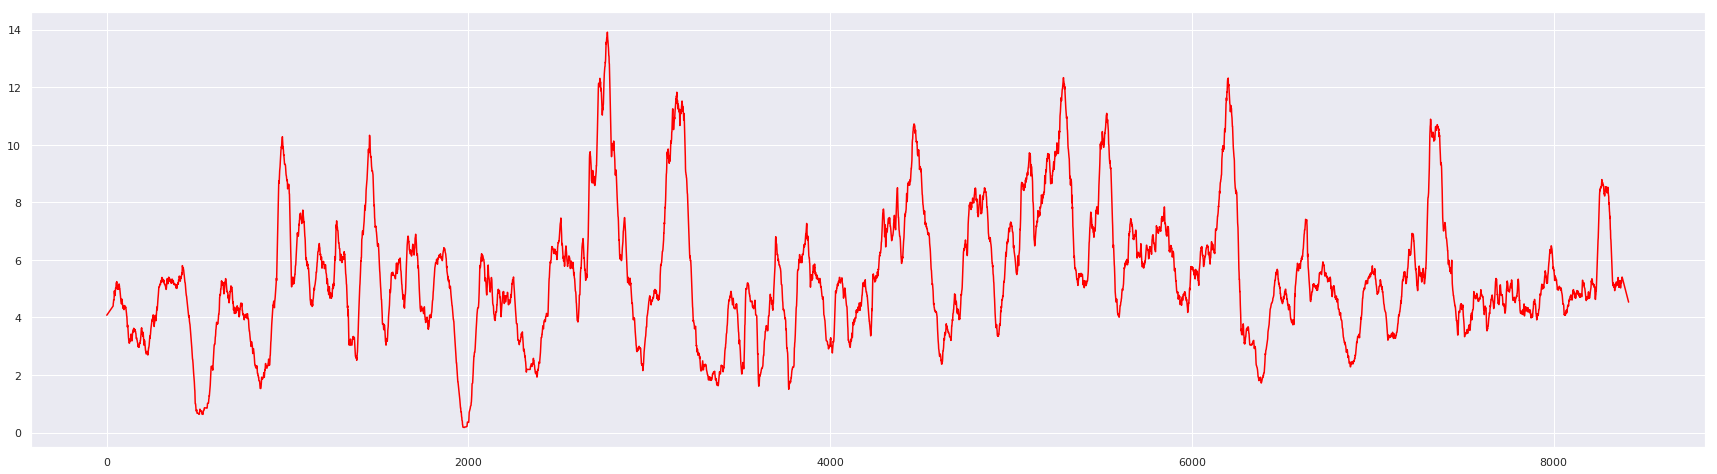

In [14]:
poseinformation['mahalanobis_minpeak'] = savgol_filter(poseinformation['mahalanobis'], window_length = 71, polyorder = 1)
plt.plot(poseinformation.index,poseinformation['mahalanobis_minpeak'], color='red')

plt.gcf().set_size_inches(30,8)
plt.show()

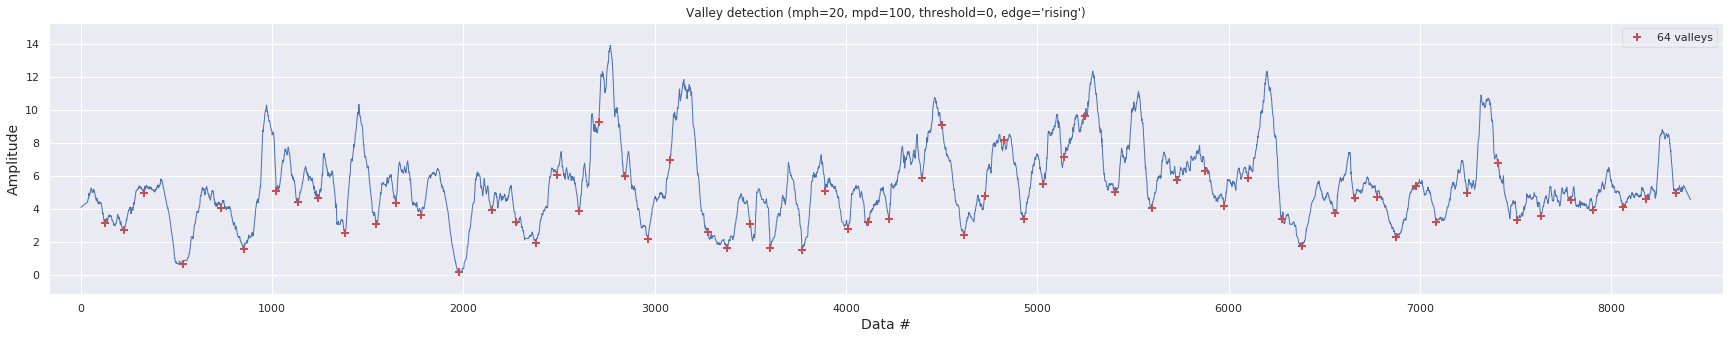

In [18]:
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.5"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=-1.2, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)

    Version history
    ---------------
    '1.0.5':
        The sign of `mph` is inverted if parameter `valley` is True
    
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(30, 5))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()
        
ind = detect_peaks(poseinformation['mahalanobis_minpeak'], mph=20, mpd=100, threshold=0, edge='rising', kpsh=False, valley=True, show=True, ax=None)


In [19]:
#Show overview of all summaries together.

poseinformation['MahalanobisSummary'] = poseinformation.iloc[ind]['Imagename']
poseinformation['UnifSamplBaseline'] = poseinformation.iloc[::100, :]['Imagename']
poseinformation['SBDBaseline'] = poseinformation[poseinformation['Imagename'].str.replace('Thesis_GLy2rYHwUqY', 'Thesis_GLy2rYHwUqY_Complete').isin(df_HistCompare_Correlation_Cuts['Imagename'])]['Imagename']
poseinformation[['MahalanobisSummary', 'UnifSamplBaseline', 'SBDBaseline']]

,MahalanobisSummary,UnifSamplBaseline,SBDBaseline
0,NaN,/content/drive/My Drive/Thesis/jpg_output/youtube_timecode_000000049758_rendered.png,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


In [20]:
#Store results before creating actual summaries.
mask = poseinformation['MahalanobisSummary'].notnull() | poseinformation['UnifSamplBaseline'].notnull() | poseinformation['SBDBaseline'].notnull()
filename = 'summary' + '_' + YOUTUBE_ID + '_' + str(FRAMESTEP) + 'fts.csv'
print(filename)

poseinformation[mask].to_csv(path_or_buf='/content/drive/My Drive/Thesis/'+filename, sep=';')

summary_Ci3na6ThUJc_6fts.csv


In [35]:
#Thanks to https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
summary2 = pd.DataFrame()
compare = []
finalpictures = []

for number in summary2.index:
  compareResult = []  
  if number == 0:
    compare = [poseinformation['Imagename'].iloc[number], poseinformation['Imagename'].iloc[number+1]]
    #print("To compare:", compare)
  else:
    try:
      compare = [poseinformation['Imagename'].iloc[number-1], poseinformation['Imagename'].iloc[number], poseinformation['Imagename'].iloc[number+1]]
      #print("To compare:", compare)
    except IndexError:
      continue  
  for imagePath in compare:    
    # load the image, convert it to grayscale, and compute the
    # focus measure of the image using the Variance of Laplacian
    # method
    strImage = str(imagePath).strip()
    image = cv.imread(strImage)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    fm = cv.Laplacian(gray, cv.CV_64F).var()
    #print(imagePath, fm)
    compareResult.append([imagePath,fm])
    index, value = max(compareResult, key=lambda item: item[1])
    finalpictures.append(index)

Selected by system: 0 images


In [0]:
YogaSummary = poseinformation.iloc[ind]['Imagename'].tolist()
list_im = sorted(set(YogaSummary))

i = 0

imgs    = [ PIL.Image.open(i) for i in list_im ]
imgs    = [i.resize((960, 540), PIL.Image.ANTIALIAS) for i in imgs]
min_shape = [(np.sum(i.size), i.size ) for i in imgs][0][1]

imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
# save that beautiful picture
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'drive/My Drive/Thesis/Yoga_Horizontal_pose_steps.png', compression='png' )    

# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'drive/My Drive/Thesis/Yoga_Vertical_pose_steps.png', compression='png' )    
Pose_Labelling_End = time.time()

In [0]:
#Create SBD Baseline summary
SBDBaselineSummary = poseinformation['SBDBaseline'][poseinformation['SBDBaseline'].notnull()].tolist()
list_im = sorted(set(SBDBaselineSummary))

i = 0

imgs    = [ PIL.Image.open(i) for i in list_im ]
imgs    = [i.resize((960, 540), PIL.Image.ANTIALIAS) for i in imgs]
min_shape = [(np.sum(i.size), i.size ) for i in imgs][0][1]

imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
# save that beautiful picture
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'drive/My Drive/Thesis/SBDBaseline_Horizontal_pose_steps.png', compression='png' )    

# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'drive/My Drive/Thesis/SBDBaseline_Vertical_pose_steps.png', compression='png' )    
Pose_Labelling_End = time.time()

In [0]:
#Create uniform sampling baseline summary
UnifSamplBaselineSummary = poseinformation['UnifSamplBaseline'][poseinformation['UnifSamplBaseline'].notnull()].tolist()
list_im = sorted(set(UnifSamplBaselineSummary))

i = 0

imgs    = [ PIL.Image.open(i) for i in list_im ]
imgs    = [i.resize((960, 540), PIL.Image.ANTIALIAS) for i in imgs]
min_shape = [(np.sum(i.size), i.size ) for i in imgs][0][1]

imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
# save that beautiful picture
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'drive/My Drive/Thesis/UnifSamplBaseline_Horizontal_pose_steps.png', compression='png' )    

# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'drive/My Drive/Thesis/UnifSamplBaseline_Vertical_pose_steps.png', compression='png' )    
Pose_Labelling_End = time.time()